# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [1]:
!pip show torch

Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\veraj\anaconda3\envs\mlcourse\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: pytorch-lightning, torchmetrics


In [2]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [3]:
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import torch
from rdkit import Chem
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
with open('pos_data.pkl', 'rb') as f:
    pos_data = pickle.load(f)

with open('type_data.pkl', 'rb') as f:
    type_data = pickle.load(f)

with open('smiles.pkl', 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load('data_split.npz')

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

formation_energy = np.load('formation_energy.npz')

fe = formation_energy['y'] # normalized formation energy
mu = formation_energy['mu']
std = formation_energy['sigma']

In [5]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 119012, test: 10000, sum: 129012


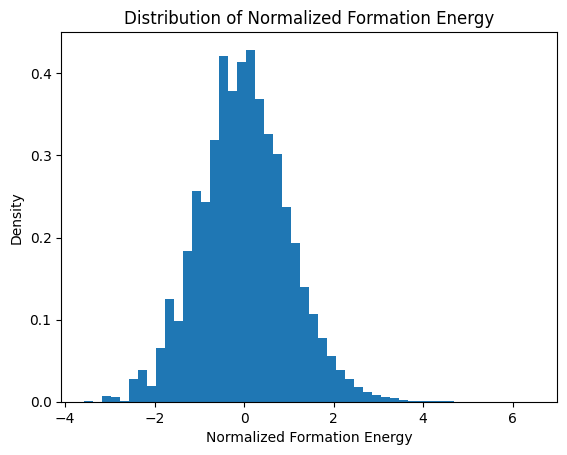

Mean of formation energy: 0.0004583929
Standard deviation of formation energy: 1.0020696
Maximum formation energy: 6.492535
Minimum formation energy: -3.5815375


In [6]:
# Check distribution of formation energy
plt.hist(fe, bins=50, density=True)
plt.xlabel('Normalized Formation Energy')
plt.ylabel('Density')
plt.title('Distribution of Normalized Formation Energy')
plt.show()

print("Mean of formation energy:", np.mean(fe))
print("Standard deviation of formation energy:", np.std(fe))
print("Maximum formation energy:", np.max(fe))
print("Minimum formation energy:", np.min(fe))

In [7]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


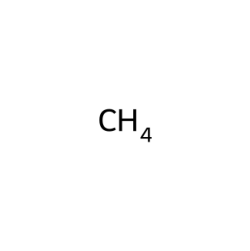

In [7]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.143│     1.521│     0.693
  C  │  6   │     0.003│     0.009│     0.543
  C  │  6   │     0.619│    -0.462│    -0.800
  C  │  6   │     1.284│    -1.791│    -0.451
  C  │  6   │     2.629│    -1.823│     0.182
  C  │  6   │     3.588│    -0.659│     0.233
  O  │  8   │     4.471│    -0.752│     1.344
  N  │  7   │     1.408│    -1.923│     1.022
  C  │  6   │     0.902│    -0.661│     1.609
  H  │  1   │     0.830│     2.022│     0.609
  H  │  1   │    -0.798│     1.937│    -0.079
  H  │  1   │    -0.570│     1.786│     1.666
  H  │  1   │    -0.991│    -0.449│     0.625
  H  │  1   │    -0.142│    -0.594│    -1.573
  H  │  1   │     1.332│     0.276│    -1.184
  H  │  1   │     0.937│    -2.679│    -0.974
  H  │  1   │     3.162│    -2.773│     0.153
  H  │  1   │     4.226│    -0.685│    -0.658
  H  │  1   │     3.069│     0.309│     0.222
  H  │  1   │     3.936│    -0.919

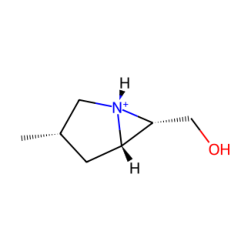

In [8]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

In [8]:
# Check device settings
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'The available device is {device}')

The available device is cpu


In [9]:
# These are some print statements inserted by me to check the data

# Check the length of the SMILES representation
print(f'Length of SMILES data: {len(smiles_data)}')
# Check the first 10 SMILES strings
print("First 10 SMILES strings:")
for i in range(10):
    print(f"{i}: {smiles_data[i]}")
# Check max lenght of SMILES strings
max_smiles_length = max(len(smile) for smile in smiles_data) # suggestion for max lenght in model
print(f'Max length of SMILES strings: {max_smiles_length}')

Length of SMILES data: 129012
First 10 SMILES strings:
0: C
1: N
2: O
3: C#C
4: C#N
5: C=O
6: CC
7: CO
8: C#CC
9: CC#N
Max length of SMILES strings: 62


## Task 1

PART II: SMILES
- String sequence to continous values
- Permutational invariance should be taken into account with canonical SMILES

In [ ]:
# Tokenize the SMILES strings
# https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00725-9
# Unclear to me whether we want to encode to values, but seems logical
class SMILESAISTokenizer:
    """
    For each atom in the molecule, it build a token in the format: 
    symbol:charge:chirality:hydrogens:ring_status:[neighbors]
    """
    def __init__(self):
        self.vocab = set()
        self.special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        self.token_to_idx = {}
        self.idx_to_token = {}
    
    def build_vocabulary(self, smiles_list):
        """
        Builds a vocabulary from a list of SMILES strings, it collect unique tokens
        returns a full vocabulary list
        """
        tokens = set()

        for smi in smiles_list:
            tokens.update(self.tokenize(smi))

        tokens = sorted(list(tokens))
        full_vocab = self.special_tokens + tokens
        self.vocab = full_vocab
        self.token_to_idx = {tok: i for i, tok in enumerate(full_vocab)}
        self.idx_to_token = {i: tok for tok, i in self.token_to_idx.items()}

        return full_vocab
    
    def tokenize(self, smiles):
        """ 
        converts a smiles string into a list of tokens, one per atom
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return []

        tokens = []
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if atom.GetIsAromatic():
                symbol = symbol.lower()

            charge = atom.GetFormalCharge()
            chiral = str(atom.GetChiralTag())
            hs = atom.GetTotalNumHs()
            ring = 'R' if atom.IsInRing() else '!R'
            neighbors = sorted([nbr.GetSymbol() for nbr in atom.GetNeighbors()])

            token = f"{symbol}:{charge}:{chiral}:{hs}:{ring}:[{','.join(neighbors)}]"
            tokens.append(token)

        return tokens

    def encode(self, smiles, max_length=None):
        """
        converts a SMILES string into a list of token indices
        """
        tokens = self.tokenize(smiles)
        # Add <SOS> and <EOS> tokens to learn start and end of sequence
        tokens = ['<SOS>'] + tokens + ['<EOS>']
        #<UNK> if it encounters a token that it has not seen before
        encoded = [self.token_to_idx.get(tok, self.token_to_idx['<UNK>']) for tok in tokens]

        if max_length:
            encoded = encoded[:max_length]
            encoded += [self.token_to_idx['<PAD>']] * (max_length - len(encoded))
        return encoded

    # def decode(self, indices): #is this needed?
    #     tokens = [self.idx_to_token.get(idx, '<UNK>') for idx in indices]
    #     tokens = [tok for tok in tokens if tok not in self.special_tokens]
    #     return tokens # Not sure whether we need decoder
    

In [24]:
# # TOY TEST
# smiles_list = [
#     "CCO",         # ethanol
#     "c1ccccc1",    # benzene
#     "C[N+](C)(C)C",# tetramethylammonium
#     "O=C=O"        # carbon dioxide
# ]

# tokenizer = SMILESAISTokenizer()
# # Initialize and build vocab
# vocab = tokenizer.build_vocabulary(smiles_list)
# print("Vocabulary size:", len(vocab))

# # Tokenize and encode a molecule
# encoded = tokenizer.encode("CCO", max_length=10)
# print("Encoded:", encoded)
# print("Decoded tokens:", tokenizer.decode(encoded))

In [ ]:
# Randomized augmentation: https://pubs.rsc.org/en/content/articlelanding/2022/dd/d2dd00058j
class SMILESDataset(Dataset):
    """
    Takes a list of SMILES strings and formation energies and tokenizes the SMILES strings.
    """
    def __init__(self, tokenizer, smiles_list, formation_energy, augment=True, max_length=None):
        self.tokenizer = tokenizer
        self.smiles = smiles_list
        self.augment = augment
        self.max_length = max_length
        self.formation_energy = formation_energy

    def __len__(self):
        return len(self.smiles)

    def randomize_smiles(self, mol):
        """ 
        randomizes the SMILES representation of a molecule to a chemically 
        equivlent SMILES for data augmentation
        """
        return Chem.MolToSmiles(mol, doRandom=True)

    def __getitem__(self, idx):
        """
        returns single datata sample of a tokenized SMILES and its formation energy
        """
        smiles = self.smiles[idx]
        mol = Chem.MolFromSmiles(smiles)
        # if mol is None: #is this needed?
        #     return self.__getitem__((idx + 1) % len(self.smiles))  # fallback

        if self.augment:
            smiles = self.randomize_smiles(mol)
        else:
            smiles = Chem.MolToSmiles(mol, canonical=True)

        encoded = self.tokenizer.encode(smiles, max_length=self.max_length)
        target = self.formation_energy[idx]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(target, dtype=torch.float32)


In [ ]:
# Create tokenzier and dataset
# Split data into train and validation 80/20, already having a test dataset
train_data = [smiles_data[i] for i in train_idxes[:-int(0.2 * len(train_idxes))]] # select first 80% of train_idxes; no overlap measured
val_data = [smiles_data[i] for i in train_idxes[-int(0.2 * len(train_idxes)):]] # select last 20% of train_idxes; no overlap measured
test_data = [smiles_data[i] for i in test_idxes]

tokenizer = SMILESAISTokenizer()
tokenizer.build_vocabulary(train_data)
max_length = 100 # the  maximum length of SMILES strings is 62, tokenization might change that

train_targets = fe[train_idxes[:-int(0.2 * len(train_idxes))]]
val_targets = fe[train_idxes[-int(0.2 * len(train_idxes)):]]
test_targets = fe[test_idxes]

train_dataset = SMILESDataset(tokenizer, train_data, train_targets, augment=True, max_length=max_length)
val_dataset = SMILESDataset(tokenizer, val_data, val_targets, augment=False, max_length=max_length)
test_dataset = SMILESDataset(tokenizer, test_data, test_targets, augment=False, max_length=max_length)

# batch size could potentially be increased with lots of data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# Transformer block
# https://pubs.rsc.org/en/content/articlelanding/2022/dd/d2dd00058j
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + self.dropout(attn_output))

        # Feed-forward network with residual connection
        mlp_output = self.mlp(x)
        x = self.layer_norm2(x + self.dropout(mlp_output))

        return x

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [15]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.regression_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, 1)  # Output a single value
        )

    def forward(self, x):
        # Input embedding + positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)

        # Pass through Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)

        # Apply LayerNorm and regression head
        x = self.layer_norm(x)
        x = x.mean(dim=1)  # Global pooling (mean over sequence length); this type of pooling should probably be changed
        x = self.regression_head(x)

        return x

In [16]:
# Inital guess for parameters
vocab_size = len(tokenizer.vocab)  # Vocabulary size from tokenizer
embed_dim = 128  # Embedding dimension
num_heads = 4  # Number of attention heads; research further the relation between embed dim and heads
ff_dim =  512 # Feed-forward network dimension; typically 4 times embedding so 1024
num_layers = 6  # Number of Transformer layers
max_len = 100  # Maximum sequence length; should be checked based on tokenization

model = TransformerDecoder(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len)

# Example input (batch of tokenized SMILES)
input_tokens = torch.randint(0, vocab_size, (32, max_len))  # Batch of 32 sequences
output = model(input_tokens)  # Output shape: (32, 1)
print(output.shape)  # Should be [32, 1]

torch.Size([32, 1])


In [17]:
# Code to train the model 
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for i, (batch, targets) in enumerate(train_loader):
            batch = batch.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (batch, targets) in enumerate(val_loader):
                batch = batch.to(device)
                targets = targets.to(device)
                outputs = model(batch)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
# Train the model;learning rate potentially lower is better 
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4)
# Save the model
torch.save(model.state_dict(), 'transformer_decoder.pth')


Epoch 1/10, Training Loss: 0.0500
Validation Loss: 0.0137
Epoch 2/10, Training Loss: 0.0086
Validation Loss: 0.0072


KeyboardInterrupt: 

In [ ]:
# # Evaluate the model on the test set
# def evaluate_model(model, test_loader):
#     model.to(device)
#     model.eval()
#     total_loss = 0.0
#     criterion = nn.MSELoss()
#     all_targets = []
#     all_predictions = []

#     with torch.no_grad():
#         for batch, targets in test_loader:
#             batch = batch.to(device)
#             targets = targets.to(device)
#             outputs = model(batch)
#             loss = criterion(outputs.squeeze(), targets)
#             total_loss += loss.item()

#             # Collect predictions and targets for MAE and R²
#             all_predictions.extend(outputs.squeeze().cpu().numpy())
#             all_targets.extend(targets.cpu().numpy())

#     avg_loss = total_loss / len(test_loader)
#     mae = mean_absolute_error(all_targets, all_predictions)
#     r2 = r2_score(all_targets, all_predictions)
#     apd = np.mean([
#         np.abs((pred - target) / target) for pred, target in zip(all_predictions, all_targets) if target != 0
#     ]) # Average Percentage Deviation based on "Understanding the language of molecules..." paper

#     print(f"Test Loss (MSE): {avg_loss:.4f}")
#     print(f"Mean Absolute Error (MAE): {mae:.4f}")
#     print(f"R² Score: {r2:.4f}")
#     print(f"Average Percentage Deviation (APD): {apd:.4f}")

In [ ]:
import torch.nn.functional as F

model.to(device)
model.eval()
test_losses = []
test_mae = []

# Ensure std and mu are tensors and on the correct device
if not isinstance(std, torch.Tensor):
    std = torch.tensor(std)
if not isinstance(mu, torch.Tensor):
    mu = torch.tensor(mu)
std = std.to(device)
mu = mu.to(device)

with torch.no_grad():
    for batch, targets in test_loader:
        batch = batch.to(device)
        targets = targets.to(device)
        
        preds = model(batch)
        original_preds = preds * std + mu
        original_targets = targets * std + mu

        mse_loss = F.mse_loss(original_preds, original_targets)
        mae_loss = F.l1_loss(original_preds, original_targets)
        
        test_losses.append(mse_loss.item())
        test_mae.append(mae_loss.item())

mean_test_loss = sum(test_losses) / len(test_losses)
mean_test_mae = sum(test_mae) / len(test_mae)

print(f"Test MSE loss (original scale): {mean_test_loss:.4f}")
print(f"Test MAE loss (original scale): {mean_test_mae:.4f}")


## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

('COO', 'COO')

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(True, True, False)